# Exploring AirBnB in Athens


* 1st Assignment of the Applied Machine Learning Class of 2023-24

---

> Author: Theodoros Skondras Mexis <br />
> Department of Management Science and Technology
> Email: t8200156@aueb.gr <br />

* First of all import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_bar, theme, element_text
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import plotly.express as px

* Then create dataframes for each one of the csv files

In [2]:
calendar = pd.read_csv("data/calendar.csv.gz")
listings = pd.read_csv("data/listings.csv.gz")
neighborhoods = pd.read_csv("data/neighbourhoods.csv")
# neighborhoods_geo = pd.read_json("data/neighbourhoods.geojson")
reviews = pd.read_csv("data/reviews.csv.gz")

* We can also get them from the website as well,
* but the data is updated every month, so the links need to be updated often, so we will use the local files instead

In [3]:
# calendar = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/data/calendar.csv.gz")
# listings = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/data/listings.csv.gz")
# neighborhoods = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/neighbourhoods.csv")
# neighborhoods_geo = pd.read_json("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/neighbourhoods.geojson")
# reviews = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/reviews.csv")

## Neighbourhood Listings in Descending Order (Popularity)

### First approach: Popularity means the number of listings per neighbourhood
* Looking at the csv files we can see that we have a listings dataset and a neighbourhood dataset, so let's see what data & columns they both have, in order to determine how to do the join (if needed)


In [4]:
listings.sample(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
9174,712931813022684203,https://www.airbnb.com/rooms/712931813022684203,20230921043851,2023-09-21,city scrape,Condo in Athina · ★4.93 · 1 bedroom · 2 beds ·...,<b>Registration number</b><br />00001761955,Plaka,https://a0.muscache.com/pictures/miso/Hosting-...,451748246,...,4.83,5.00,4.90,00001761955,f,1,1,0,0,2.39
12438,940354467519027545,https://www.airbnb.com/rooms/940354467519027545,20230921043851,2023-09-21,city scrape,Rental unit in Athina · ★New · 1 bedroom · 1 b...,The studio features a comfortable queen-sized ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,525418513,...,5.00,5.00,5.00,00001294111,t,9,9,0,0,2.00
665,12923641,https://www.airbnb.com/rooms/12923641,20230921043851,2023-09-21,city scrape,Rental unit in Athina · ★4.48 · 1 bedroom · 1 ...,Small apartment 33 s.m. near the city center f...,SOUVLAKI<br />There are 2 souvlaki restaurants...,https://a0.muscache.com/pictures/70425d22-9c49...,7044925,...,4.62,4.52,4.76,00000462586,f,1,1,0,0,0.26


In [5]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

* We can see that listings has plenty of neighbourhood-related columns, so we can determine which one of them to join the two datasets, let's take only them with the help of a regex expression

In [6]:
listings.filter(regex="neighbourhood").sample(3)

,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
2709,Plaka,"Athina, Greece",ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,NaN
10273,NaN,"Athina, Greece",ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,NaN
7814,NaN,"Athina, Greece",ΚΥΨΕΛΗ,NaN


In [7]:
neighborhoods.sample(3)

,neighbourhood_group,neighbourhood
7,NaN,ΑΝΩ ΚΥΨΕΛΗ
13,NaN,ΓΟΥΔΙ
11,NaN,ΓΚΥΖΗ


* We can see that both datasets have a column that seems to have similar data, neighbourhood_cleansed in listings and neighbourhood in neighborhoods, so let's see if they have the same values

In [8]:
neighborhood_names_neighbourhoods = neighborhoods["neighbourhood"].unique()
neighborhood_names_listings = listings["neighbourhood_cleansed"].unique()

#check if the values of the second array are in the first array using numpy
result = np.all(np.isin(neighborhood_names_listings, neighborhood_names_neighbourhoods))
print(result)

True


* We can see that the values on the listings dataset are a subset of the values of the neighborhoods dataset, so we can use the neighbourhood_cleansed columnn to show the listings per neighbourghood, with the most popular neighbourhoods first, without the need to join the two datasets

In [9]:
listings_per_neighbourhood = listings.groupby("neighbourhood_cleansed").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_listings"})

In [10]:
listings_per_neighbourhood

,total_listings
neighbourhood_cleansed,
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,2416
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,1122
ΝΕΟΣ ΚΟΣΜΟΣ,980
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,979
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ,817
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ,583
ΠΑΓΚΡΑΤΙ,511
ΑΜΠΕΛΟΚΗΠΟΙ,452
ΚΟΛΩΝΑΚΙ,425


* Now that we have the data we need, let's visualize them too.
* The iloc[::-1] will be used to reverse the order of the dataframe, so that the most popular neighbourhoods will be on top
* We prefer a horizontal bar plot, because it is easier to read the names of the neighbourhoods

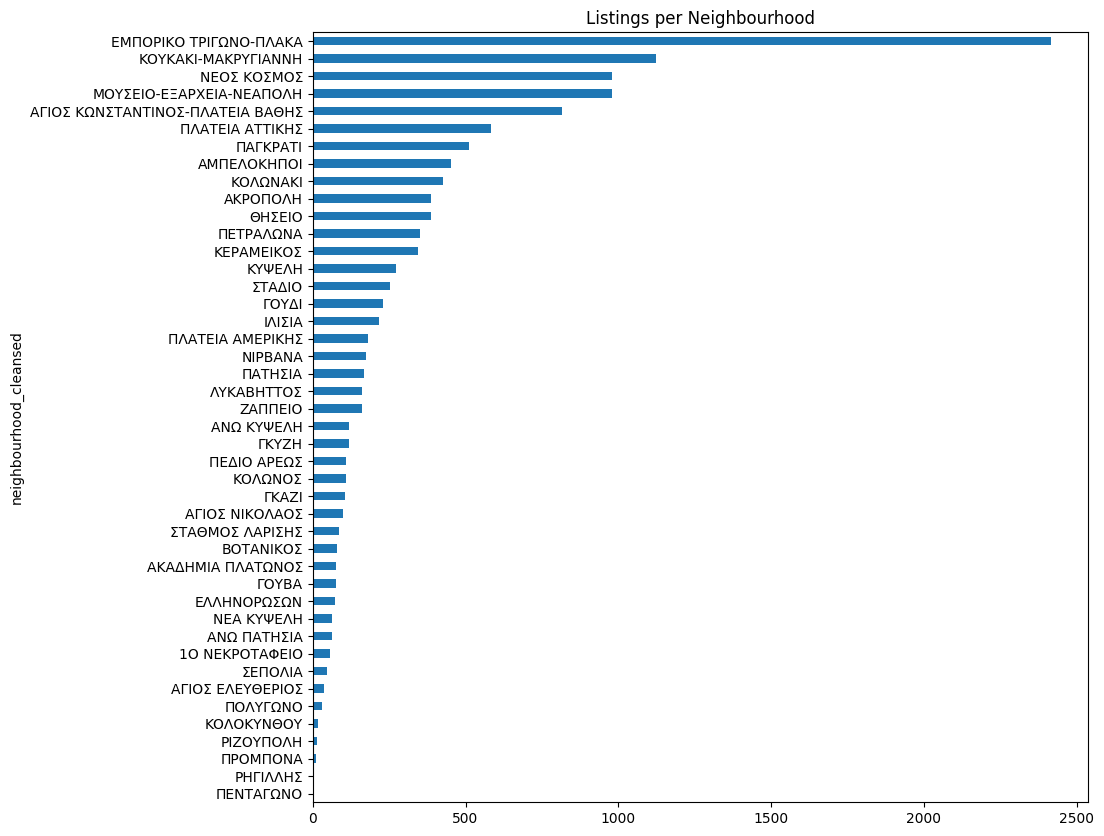

In [11]:
# reverse the order of the dataframe, and create a horizontal bar plot
listings_per_neighbourhood.iloc[::-1].plot.barh(figsize=(10, 10), legend=False,title="Listings per Neighbourhood")
plt.show()

### Second approach: Popularity means the number of reviews per neighbourhood

* We can also use the reviews dataset to determine the popularity of a neighbourhood, by counting the number of reviews per neighbourhood
* Let's see a sample of the data

In [12]:
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
136440,16334929,174220443,2017-07-25,16022295,Hélio,The apartment was really perfect. It's been re...
344394,30058424,437090647,2019-04-14,32918853,Cansu,A very hospitable and helpful host who replies...
204725,20967829,463355153,2019-06-03,95413889,Grażyna,"The place has a uniqe, unforgettable atmospher..."


* We can see that we have a listing_id column, so we can join the two datasets in order to have the neighbourhood_cleansed column as well

In [13]:
# create a new df that has the neighbourhood_cleansed column for each one of the reviews
reviews_listings = reviews.merge(listings[["id", "neighbourhood_cleansed"]], left_on="listing_id", right_on="id")
reviews_listings.sample(3)

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,neighbourhood_cleansed
446138,38110538,528961630,2019-09-14,79674524,Gillian,Great location sparkling clean,38110538,1Ο ΝΕΚΡΟΤΑΦΕΙΟ
532017,50812562,943322918633567447,2023-07-25,78668113,Ioannis,Another great stay at one of Youla’s apartment...,50812562,ΠΑΓΚΡΑΤΙ
452601,39098766,553389444,2019-10-24,6766425,Constantinos,We really loved this place: it's homey and spa...,39098766,ΙΛΙΣΙΑ


* Let's do a value count on the neighbourhood_cleansed column to see the number of reviews per neighbourhood, assign it to a dataframe

In [14]:
reviews_per_neighbourhood = reviews_listings["neighbourhood_cleansed"].value_counts()
reviews_per_neighbourhood

neighbourhood_cleansed
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              155818
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                  75216
ΝΕΟΣ ΚΟΣΜΟΣ                          47481
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ     37690
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ             37621
ΑΚΡΟΠΟΛΗ                             28135
ΘΗΣΕΙΟ                               28087
ΚΕΡΑΜΕΙΚΟΣ                           19722
ΠΑΓΚΡΑΤΙ                             19022
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                      17754
ΖΑΠΠΕΙΟ                              16339
ΠΕΤΡΑΛΩΝΑ                            15995
ΑΜΠΕΛΟΚΗΠΟΙ                          15508
ΚΟΛΩΝΑΚΙ                             14437
ΣΤΑΔΙΟ                               11620
ΓΚΑΖΙ                                 8348
ΚΥΨΕΛΗ                                7540
ΙΛΙΣΙΑ                                6666
ΝΙΡΒΑΝΑ                               6259
ΓΟΥΔΙ                                 6163
ΛΥΚΑΒΗΤΤΟΣ                            5215
ΒΟΤΑΝΙΚΟΣ                             4679
ΚΟΛΩΝΟΣ                        

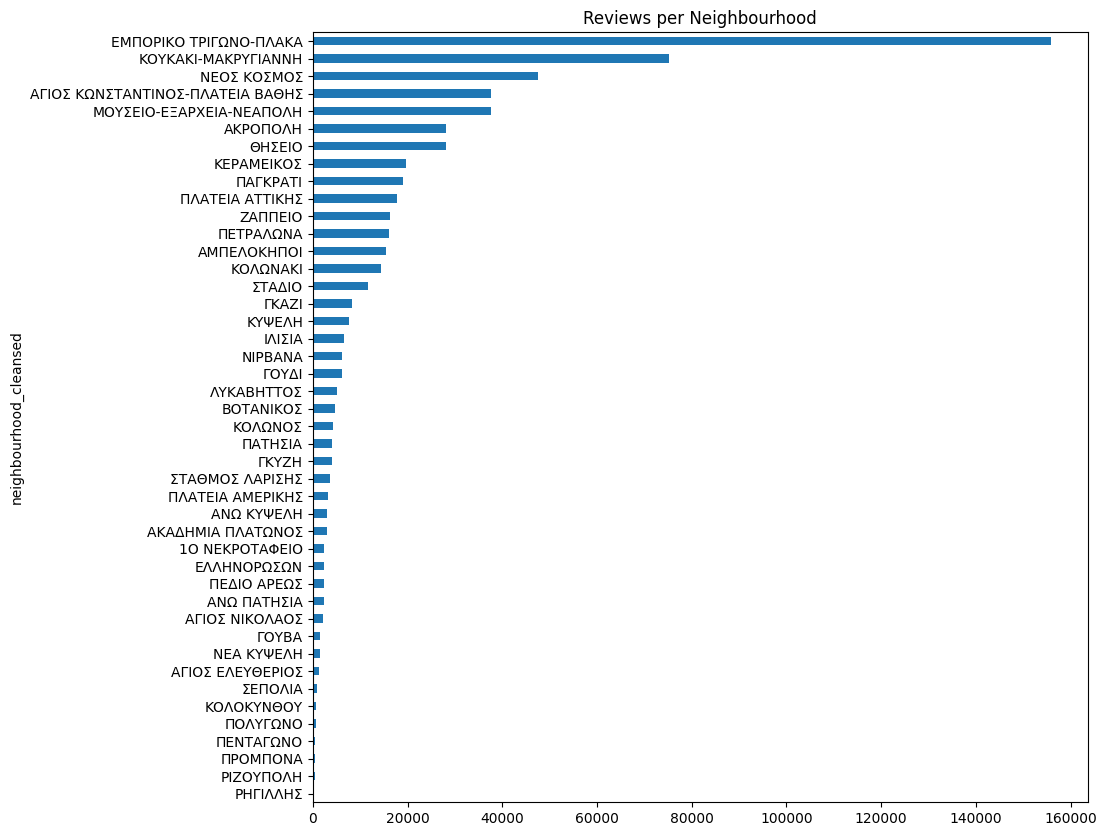

In [15]:
reviews_per_neighbourhood[::-1].plot.barh(figsize=(10, 10), legend=False,title="Reviews per Neighbourhood")
plt.show()

* As simple as that, we have the number of reviews per neighbourhood, let's visualize them
* First we will need to normalize the data so that each cell will have a percentage between 0 and 1, as reviews and listings are not the same range of values

In [16]:
# normalize the data so that each cell will have a percentage between 0 and 1
reviews_per_neighbourhood_normalized = reviews_per_neighbourhood / reviews_per_neighbourhood.sum()
listings_per_neighbourhood_normalized = listings_per_neighbourhood / listings_per_neighbourhood.sum()

In [17]:
# create a new dataframe that has the number of listings and the number of reviews per neighbourhood normalized
listings_reviews_per_neighbourhood_normalized = pd.concat([listings_per_neighbourhood_normalized, reviews_per_neighbourhood_normalized], axis=1)
listings_reviews_per_neighbourhood_normalized.columns = ["listings", "reviews"]
listings_reviews_per_neighbourhood_normalized

,listings,reviews
neighbourhood_cleansed,,
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,0.186492,0.247103
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,0.086607,0.119281
ΝΕΟΣ ΚΟΣΜΟΣ,0.075646,0.075298
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,0.075569,0.059661
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ,0.063064,0.059771
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ,0.045002,0.028155
ΠΑΓΚΡΑΤΙ,0.039444,0.030166
ΑΜΠΕΛΟΚΗΠΟΙ,0.034890,0.024593
ΚΟΛΩΝΑΚΙ,0.032806,0.022895


* It is already visible that except some minor differences, the popularity is on the same level for both approaches, let's also visualize them

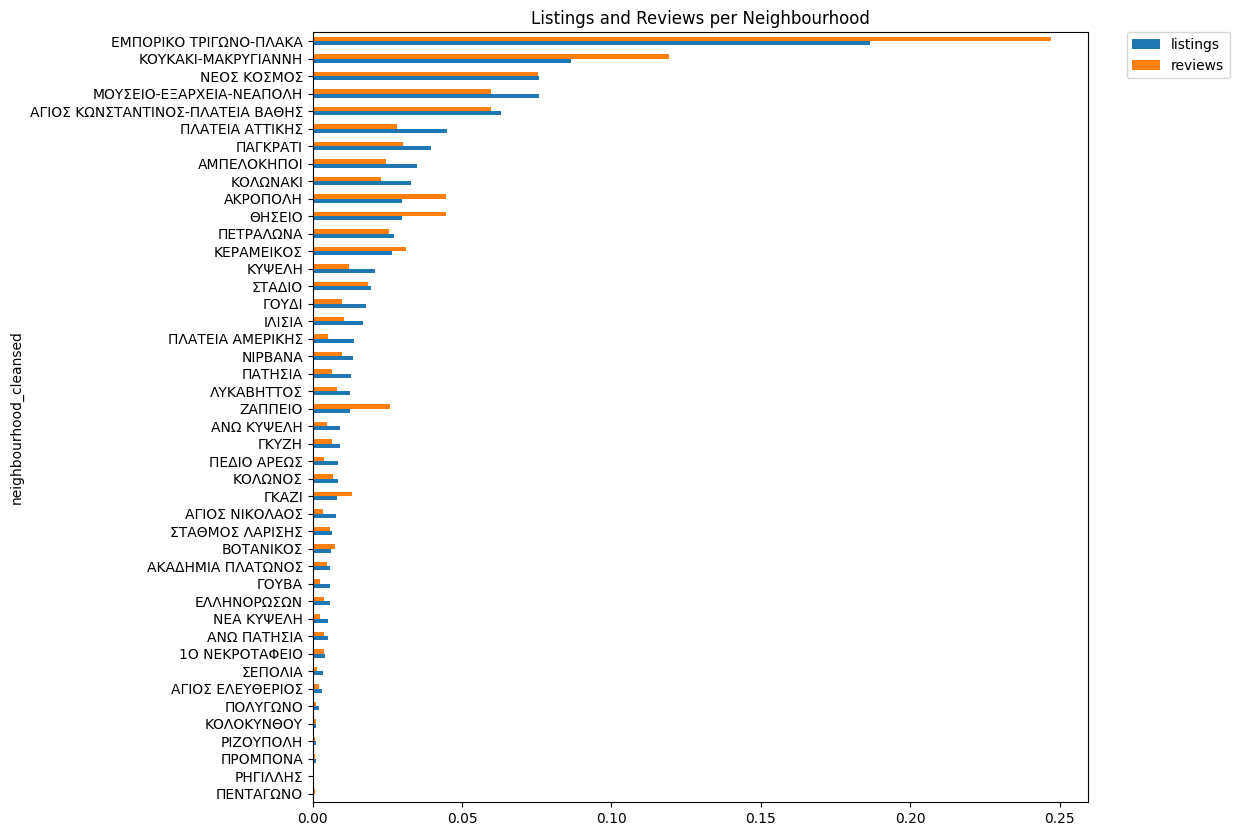

In [18]:
listings_reviews_per_neighbourhood_normalized[::-1].plot.barh(figsize=(10, 10), title="Listings and Reviews per Neighbourhood")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

* Interesting... we can see that the neighbourhoods of which their number of reviews do not follow the same pattern as the number of listings (they are mentionably higher percent-wise) are Plaka,Koukaki,Acropolis,Zappeion and others.
* Maybe in more expensive and high-value neighbourhoods, guests tend to leave more reviews? Nonetheless, the differences between the two are not that major

## Neighbourhood Prices in Descending Order

* Now let's see the prices per neighbourhood
* If we look carefully at the listings' columns above, we see that the price is there so we do not need joins again.
* Are there any outliers though?

In [19]:
listings["price"].describe()

count      12955
unique       507
top       $50.00
freq         414
Name: price, dtype: object

* Interesting, we do not get the statistics we expected, maybe because of the dollar data type? Let's convert it to float and try again

In [20]:
listings["price"] = listings["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [21]:
listings["price"].describe()

count    12955.000000
mean       110.458587
std        738.185656
min         10.000000
25%         50.000000
50%         71.000000
75%        113.000000
max      80275.000000
Name: price, dtype: float64

* The max value seems a bit high, let's see the distribution of the prices

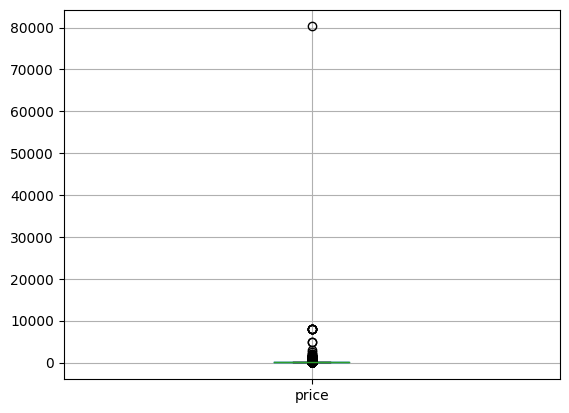

In [22]:
listings.boxplot(column="price")
plt.show()

* We can see that there are some outliers, everything below the 10000 dollar price point seems reasonable, so let's filter the dataframe to see the prices above 10000 dollars and below 0

In [23]:
listings[(listings["price"] > 10000) | (listings["price"] < 0)][["id", "price","neighbourhood_cleansed"]]

,id,price,neighbourhood_cleansed
3641,32463338,80275.0,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ


* Unless a palace is listed on AirBnB, the price of 80000 seems unreasonable, so let's filter it out and create another boxplot as well as the basic descriptive statistics

In [24]:
listings_normal_prices = listings[listings["price"] < 80000]
listings_normal_prices["price"].describe()

count    12954.000000
mean       104.270187
std        220.891911
min         10.000000
25%         50.000000
50%         71.000000
75%        113.000000
max       8000.000000
Name: price, dtype: float64

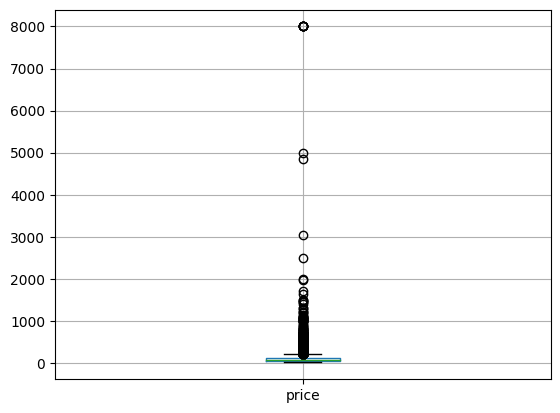

In [25]:
listings_normal_prices.boxplot(column="price")
plt.show()

* We see that the max value, mean and std have been reduced significantly just by removing a single outlier
* But we still see that there are still some outliers, we could use z-score or IQR to remove them, but let's see some screenshots of the listings on AirBnB to see the range of prices.
* Since we have access to airbnb data for athens, let's check out what is the price range for a single night in a hotel in Athens


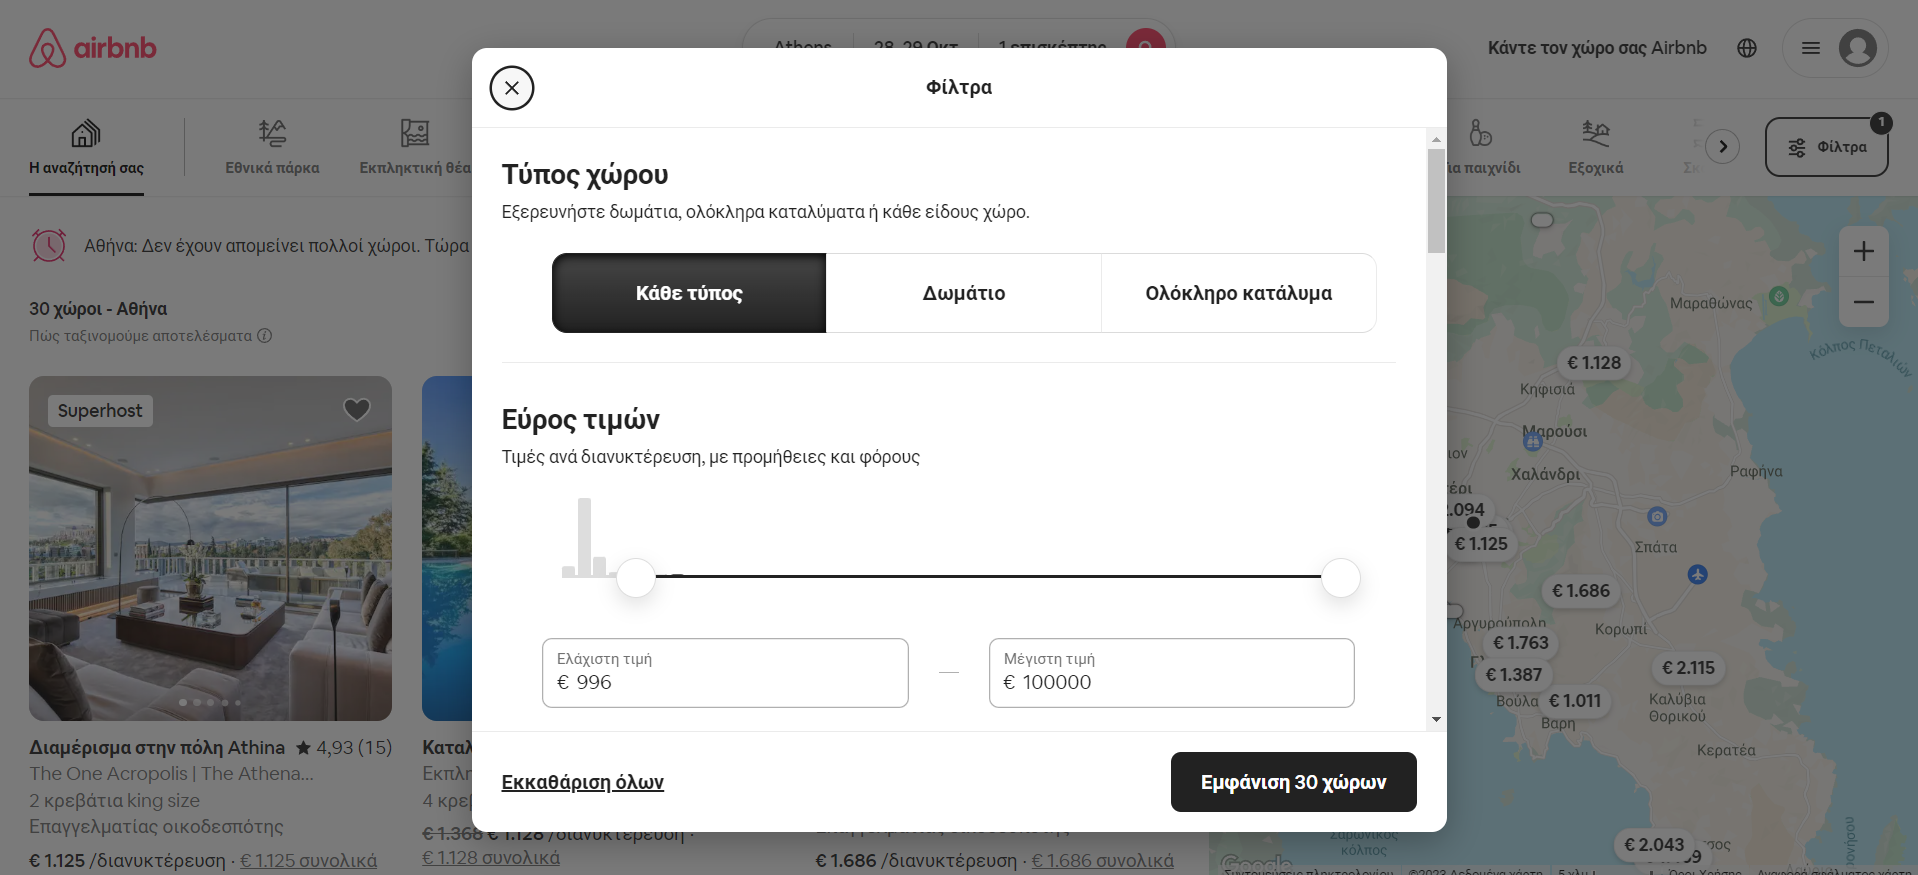

In [26]:
from IPython.display import Image
Image(filename='images/expensive_airbnbs_athens.png')

* It seems real that there are plenty of listings with prices close or above the 1000 euro-range (30)
* Let's see the most expensive listing in Athens

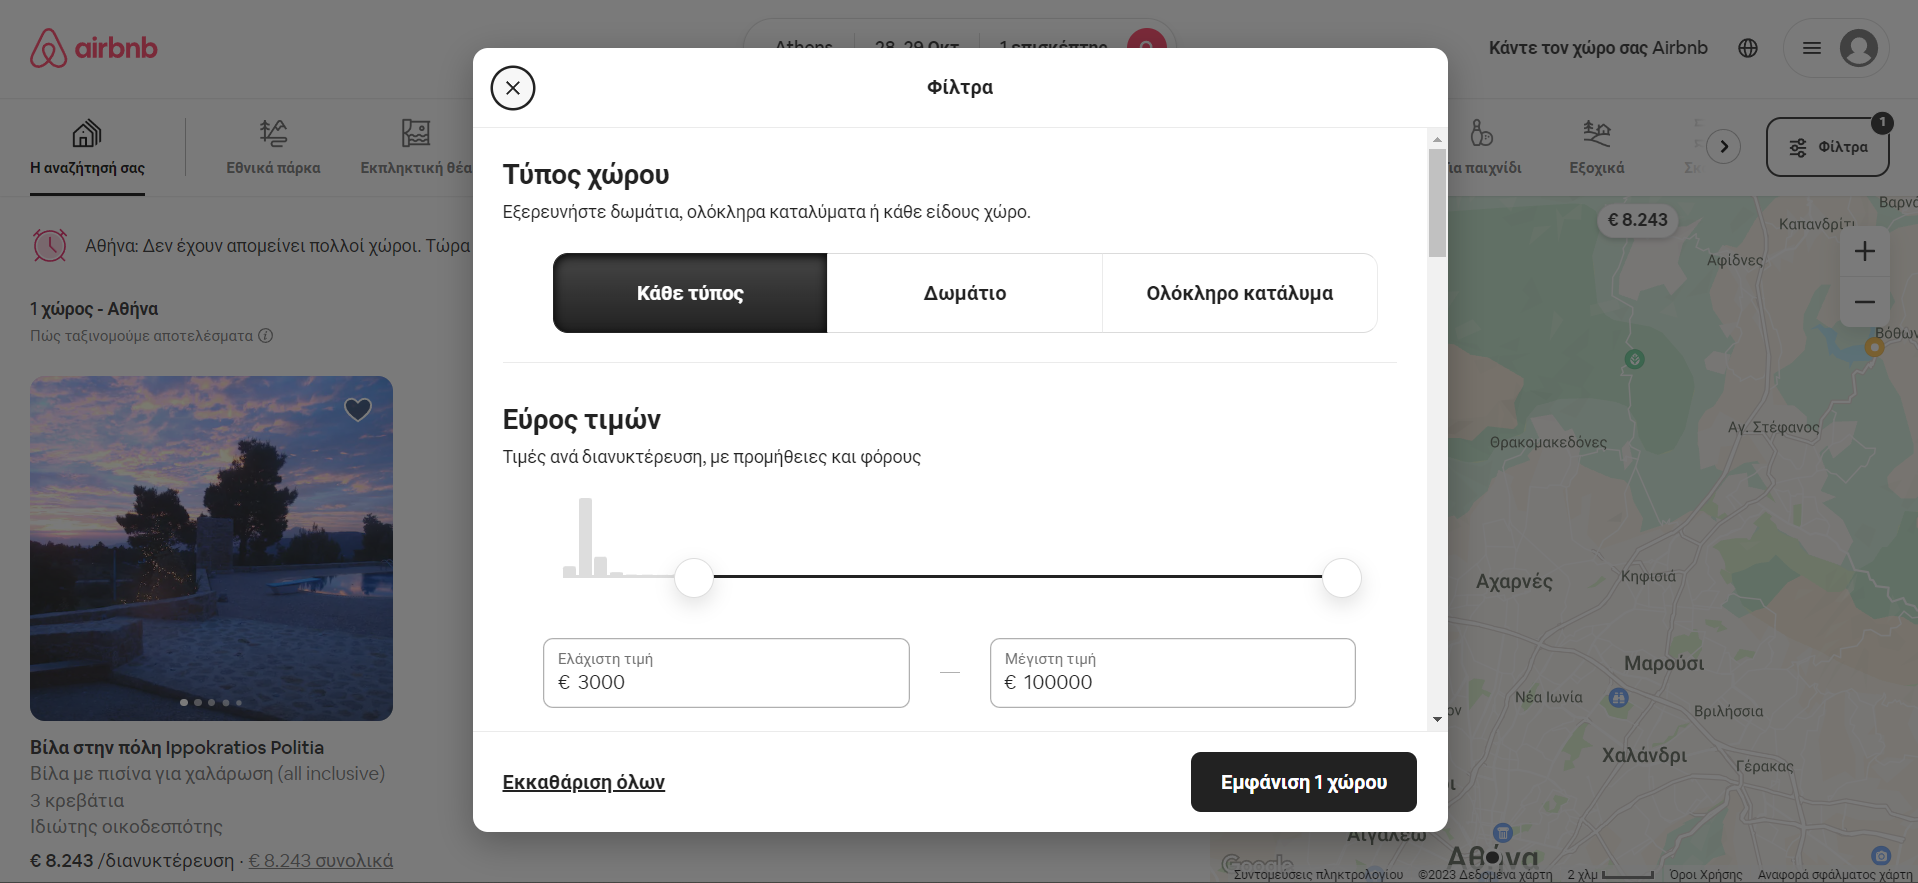

In [27]:
Image(filename='images/most_expensive_airbnb.png')

* Indeed, the most expensive listing is a whole villa costing a bit over 8000 euros, so the data make sense
* But statistically they remain outliers, so we will use IQR to remove them since it is one of the most common methods to remove outliers.
* It is important to mention that we could use other methods z-score as well.
* For further information regarding IQR, you can check out: https://en.wikipedia.org/wiki/Interquartile_range, https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [28]:
# find the IQR
Q1 = listings_normal_prices["price"].quantile(0.25)
Q3 = listings_normal_prices["price"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

63.0


In [29]:
# remove the outliers
listings_normal_prices = listings_normal_prices[~((listings_normal_prices["price"] < (Q1 - 1.5 * IQR)) | (listings_normal_prices["price"] > (Q3 + 1.5 * IQR)))]

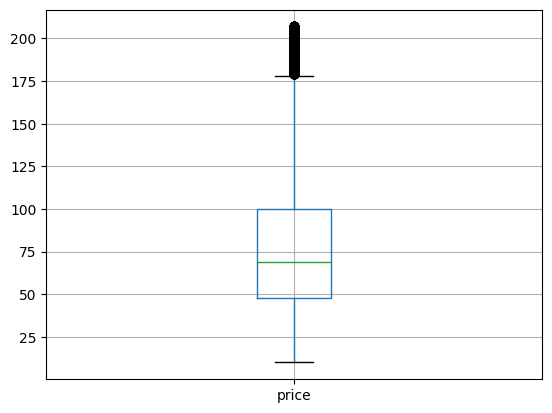

In [30]:
listings_normal_prices.boxplot(column="price")
plt.show()

* We are on a much better spot now, let's see the prices per neighbourhood

In [31]:
listings_per_neighbourhood_prices = listings_normal_prices.groupby("neighbourhood_cleansed").agg({"price": ["median", "mean", "std", "count"]}).sort_values(by=("price", "median"), ascending=False)
listings_per_neighbourhood_prices.columns = ["median", "mean", "standard deviation", "number of listings"]

In [32]:
listings_per_neighbourhood_prices

,median,mean,standard deviation,number of listings
neighbourhood_cleansed,,,,
ΖΑΠΠΕΙΟ,96.0,101.838710,47.141439,124
ΡΗΓΙΛΛΗΣ,96.0,109.750000,49.735132,4
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,95.0,101.299182,42.247004,2079
ΚΟΛΩΝΑΚΙ,90.0,98.102981,41.661227,369
ΑΚΡΟΠΟΛΗ,89.0,99.324324,44.838632,333
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,86.0,94.471866,41.167791,1013
ΚΕΡΑΜΕΙΚΟΣ,83.0,92.196667,42.181698,300
ΘΗΣΕΙΟ,81.0,92.005970,40.274432,335
ΛΥΚΑΒΗΤΤΟΣ,71.5,83.358108,39.953376,148


## Availability per Day

* Let's see the availability per day, first by looking at the calendar dataset

In [33]:
calendar.sample(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
302778,14065549,2024-04-01,t,$60.00,$60.00,2,1125
820376,24712001,2024-04-10,t,$49.00,$49.00,3,1125
2070032,44698337,2023-12-28,t,$63.00,$63.00,3,1125


In [34]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

* Seems like the columns available,date and listing_id will be used, let's see their values

In [35]:
calendar[["listing_id","date","available"]].sample(3)

,listing_id,date,available
481755,18731637,2024-07-18,t
1658802,37252437,2024-05-01,t
3829770,848511725095324399,2024-03-10,t


In [36]:
#check if calendar has the same listings as the listings dataset
listings_ids_calendar = calendar["listing_id"].unique()
listings_ids_listings = listings["id"].unique()
np.all(np.isin(listings_ids_listings,listings_ids_calendar))

True

* Seems like the values are either t or f, probably meaning true or false, let's take a look also on the listings dataset to see if there are similar columns

In [37]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [38]:
listings.filter(regex="availability").sample(3)

,has_availability,availability_30,availability_60,availability_90,availability_365
557,f,0,0,0,0
4543,t,14,44,74,349
10953,t,23,53,83,217


* Seems like we have availability columns but no date ones, which makes sense to be only in the calendar dataset, so we will not need a join again.

In [39]:
availability_per_day = calendar[calendar["available"] == "t"].groupby("date").count().sort_values(by="date", ascending=True)[["listing_id"]].rename(columns={"listing_id": "total_listings"})
# we will convert the index to datetime, in order to plot it in a more readable way
availability_per_day.index = pd.to_datetime(availability_per_day.index)
availability_per_day

,total_listings
date,
2023-09-21,540
2023-09-22,982
2023-09-23,1475
2023-09-24,2495
2023-09-25,3194
...,...
2024-09-15,7532
2024-09-16,7535
2024-09-17,7532


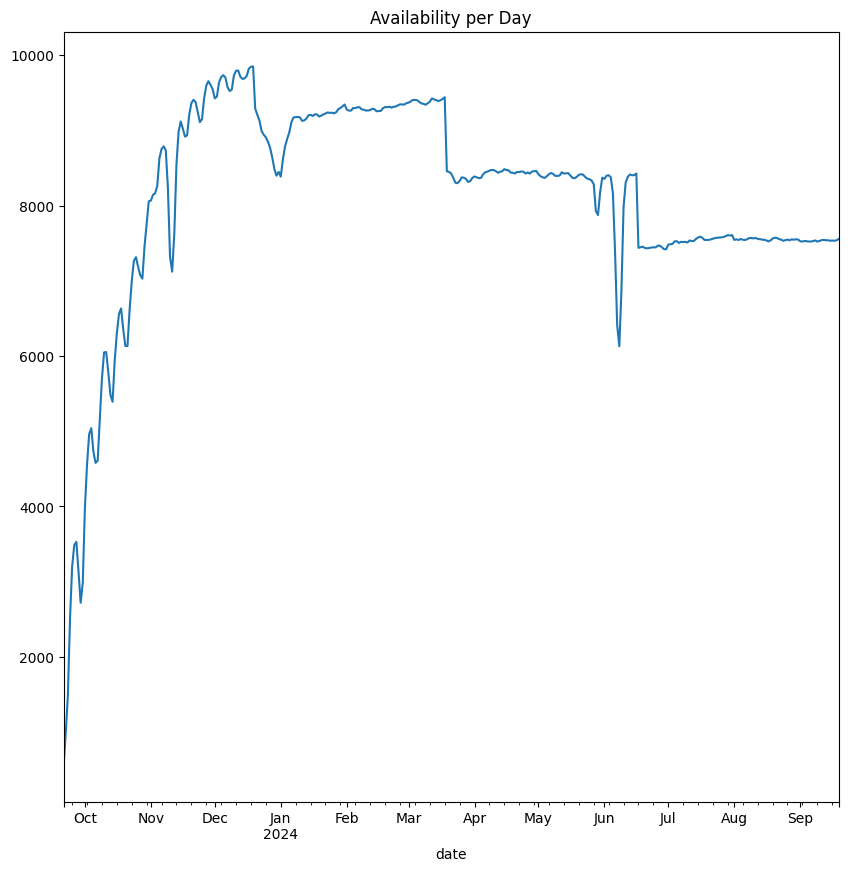

In [40]:
availability_per_day.plot(figsize=(10, 10), legend=False,title="Availability per Day")
plt.show()

* The graph seems correct, as we can see that the availability is drops in the summer months, which is the high season for tourism in Greece, and around Christmas too.

## Reviews, Occupacy per Listing, Average Income

* Let's see the reviews dataset

In [41]:
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
327418,28553327,737001558,2021-03-07,265880233,Σάρα,Το σπίτι ήταν υπέροχο. Ο χώρος ήταν πολύ άνετο...
147574,17350984,952031708346257657,2023-08-06,297553260,Alex,Our short (1 night) stay before flying home wa...
459234,39980872,672870581,2020-10-10,61258310,Tarek,appartement propre et fonctionnel je recommande


In [42]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

* Seems like again we will not need joins. Just group by listing_id and get the count of reviews, ascending, keeping only one column and naming it total_reviews

In [43]:
reviews_per_listing = reviews.groupby("listing_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_reviews"})

In [44]:
reviews_per_listing

,total_reviews
listing_id,
1177492,865
3431705,856
13553080,778
14583913,764
5025556,731
...,...
40811117,1
40819345,1
841346347093410091,1


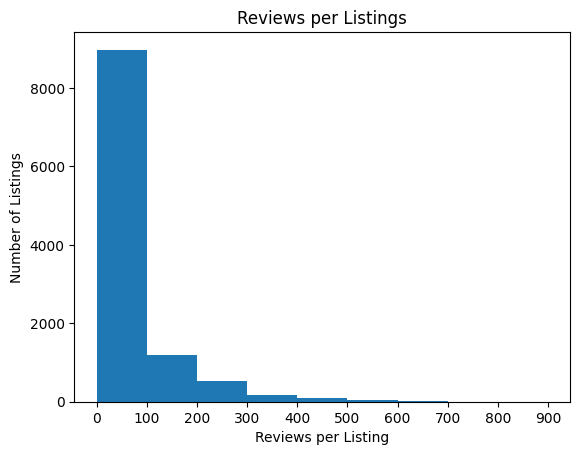

In [45]:
min = 0
max = reviews_per_listing["total_reviews"].max()
plt.hist(reviews_per_listing["total_reviews"], bins=range(min, max + 100, 100))
plt.title('Reviews per Listings')
plt.xlabel("Reviews per Listing")
plt.ylabel("Number of Listings")
plt.xticks(range(min, max + 100, 100))
plt.show()

* We see that most listings have less than 100 reviews, the ones with a lot of reviews are not that many, let's see the same graph with a log scale to see the small bars better.

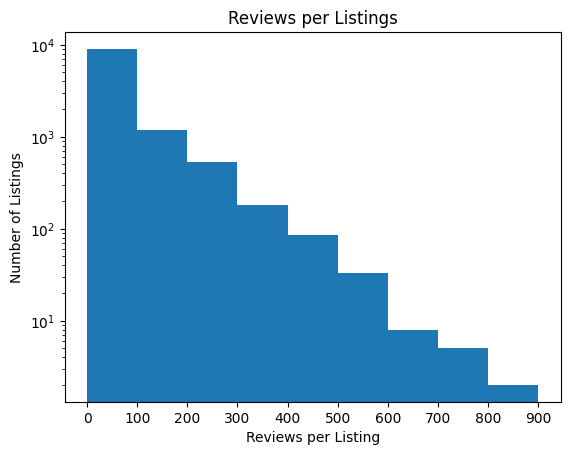

In [46]:
plt.hist(reviews_per_listing["total_reviews"], bins=range(min, max + 100, 100))
plt.title('Reviews per Listings')
plt.xlabel("Reviews per Listing")
plt.ylabel("Number of Listings")
plt.yscale("log")
plt.xticks(range(min, max + 100, 100))
plt.show()

* Let's move on finding the average occupacy per listing per month, assuming that half of the bookings result in reviews.
* Let's start by seeing the columns in listings that have to do with reviews

In [47]:
listings.filter(regex="review").sample(3)

,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
11047,3,3,1,2023-08-14,2023-09-10,4.33,4.00,5.00,4.00,5.00,4.00,4.67,2.31
2164,124,8,2,2018-04-23,2023-09-10,4.90,4.95,4.95,4.92,4.95,4.97,4.77,1.88
8720,13,11,1,2022-09-09,2023-09-05,5.00,4.92,5.00,4.77,4.92,4.85,5.00,1.03


* Seems like we have a column named reviews_per_month, which probably contains historic values
* As a result we can find the average reviews per month, either by analyzing the current data from the reviews dataset, or by using the historic data from the listings dataset.
* Let's start by using the current data from the reviews dataset and then compare the results with the historic data from the listings dataset.

In [48]:
#convert the date column to datetime
reviews["date"] = pd.to_datetime(reviews["date"])

In [49]:
# group the reviews by listing_id and count the reviews
reviews_per_listing_per_month = reviews.groupby("listing_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_reviews"}) / 12
reviews_per_listing_per_month.sample(3)

,total_reviews
listing_id,
858798248955867180,0.250000
21222340,5.166667
54155868,7.916667


In [50]:
# we assume that half of the bookings result in reviews, so we multiply by 2
average_bookings_per_listing_per_month = reviews_per_listing_per_month["total_reviews"].mean() *2
average_bookings_per_listing_per_month

9.555080764918024

* So, with the first approach, we can see that the average occupacy per listing per month is approximately 9.5
* Now let's try the second approach, using the historic data from the listings dataset

In [51]:
# use the listing dataset to get the reviews_per_month column
reviews_per_month = listings[["id", "reviews_per_month"]] * 2
reviews_per_month["reviews_per_month"].mean()

3.591542867533412

* Interestingly, the second historic approach gives us an occupacy of approximately 3.6, which is way lower than the first approach.
* Why? One thought is that the occupacy has increased over the years, so the historic data is not accurate.
* Another thought is that the reviews_per_month column is not accurate, and it is not the actual number of reviews per month. Will have to ask the owners of the dataset.
* What we can do right now is to search in forums or in the AirBnB website for further information. In most forums, the answers range from 21-28 days per month.
* If we suppose that each booking is for a three night stay, the first approach gives us 28.5 days, and the second one gives us 10.8 days. Based only on the forum responses, the second approach seems to be more correct.
* For instance, check out: https://lovethemaldives.com/faq/how-often-are-airbnbs-rented-out

* Let's move on to the average income per listing per month, using the first approach about the occupacy
* We will use the average occupacy per listing per month, and the listings_normal_prices that we calculated earlier, to find the average income per listing per month

In [52]:
# multiply by 3 as we assume that each booking is for a three night stay
average_income_per_listing_per_month = average_bookings_per_listing_per_month * listings_normal_prices["price"].mean() * 3
average_income_per_listing_per_month

2252.766386608465

* The income may seem high, for greek standards, do not forget that we have not taken into account fees, taxes, operational costs, etc., plus the fact that we are talking about listings mainly in the center of Athens.

## Listings per Room Type

* Show the number of listings per room type, in absolute numbers, and also in percentages (the percentage of listings for each particular room type). Then, show the number of listings per neighrbourhood and room type
* Let's see the room types first

In [53]:
# find all the columns that contain the word room
listings.filter(regex="room").sample(3)

,room_type,bathrooms,bathrooms_text,bedrooms,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
4907,Entire home/apt,NaN,1 bath,1.0,12,0
12094,Entire home/apt,NaN,1 bath,1.0,0,0
4353,Private room,NaN,1.5 shared baths,NaN,3,0


* Seems like we have the room_type column, let's see its values

In [54]:
listings["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [55]:
# group by room type and count the number of listings
listings_per_room_type = listings.groupby("room_type").count().sort_values(by="id", ascending=True)[["id"]].rename(columns={"id": "total_listings"})
listings_per_room_type

,total_listings
room_type,
Shared room,85
Hotel room,105
Private room,1113
Entire home/apt,11652


* Let's see the number of listings per room type as absolute numbers.
* We will use a horizontal bar chart, since it is easier to read the room types

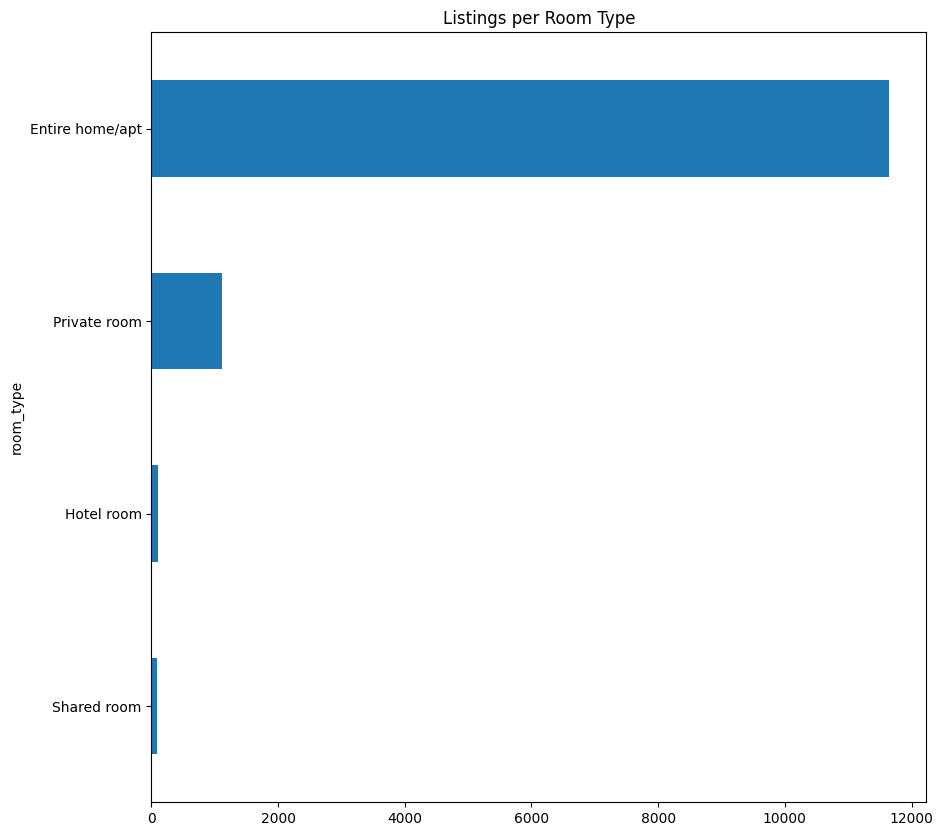

In [56]:
listings_per_room_type.plot.barh(figsize=(10, 10), legend=False,title="Listings per Room Type")
plt.show()

* For the percentage of listings per room type, we will use a pie chart that is better suited for percentages

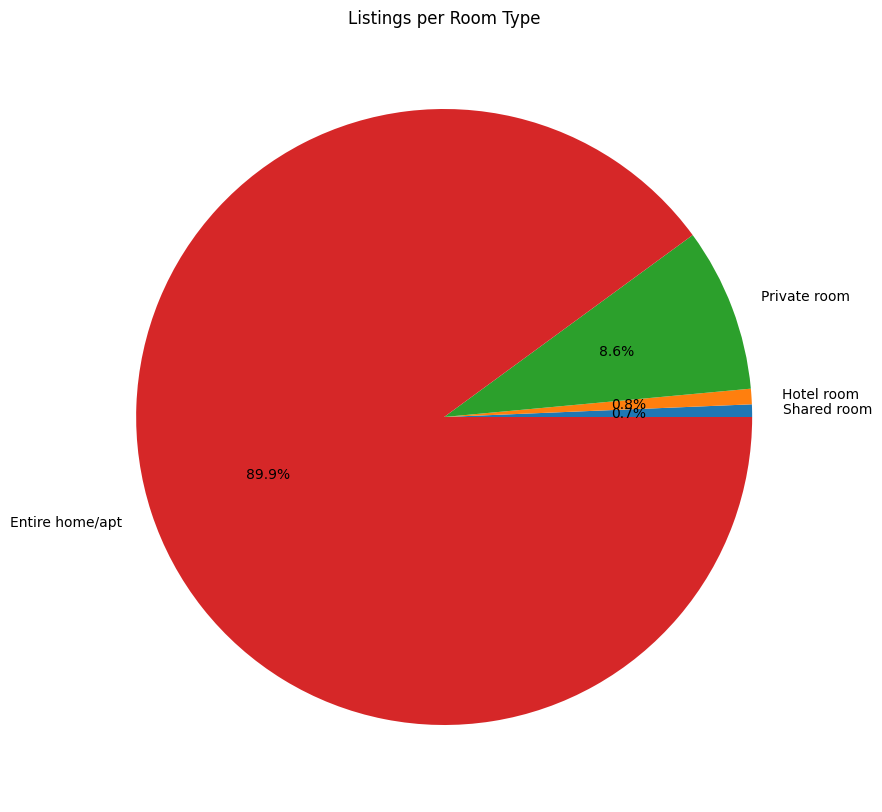

In [57]:
listings_per_room_type["total_listings"].plot.pie(figsize=(10, 10), autopct='%1.1f%%', labels=listings_per_room_type.index,title="Listings per Room Type")
plt.ylabel("")
plt.show()

* Let's see the number of listings per neighbourhood and room type

In [58]:
listings_per_neighbourhood_room_type = listings.groupby(["neighbourhood_cleansed", "room_type"]).count().sort_values(by="id", ascending=True)[["id"]].rename(columns={"id": "total_listings"})
listings_per_neighbourhood_room_type.sample(3)

,,total_listings
neighbourhood_cleansed,room_type,
ΑΝΩ ΠΑΤΗΣΙΑ,Entire home/apt,61
ΠΕΤΡΑΛΩΝΑ,Hotel room,2
ΑΝΩ ΠΑΤΗΣΙΑ,Private room,3


* Again we will use a horizontal bar chart, since it is easier to read the neighbourhoods and compare different types of rooms

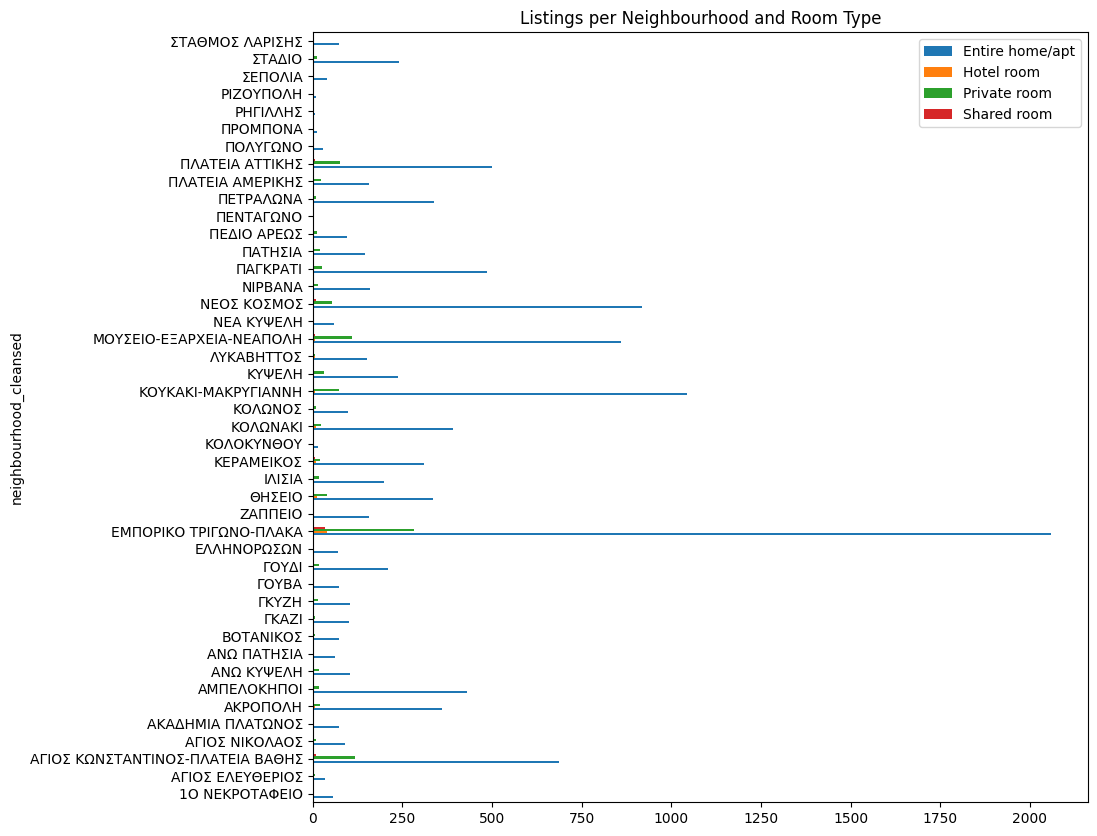

In [59]:
listings_per_neighbourhood_room_type.unstack().plot.barh(figsize=(10, 10), legend=False,title="Listings per Neighbourhood and Room Type")
# add the legend
plt.legend(listings_per_neighbourhood_room_type.index.levels[1])
plt.show()

## Prices per Day

* Let's check the prices, they are in both the calendar and the listings dataset as we saw earlier, we will prefer the calendar data since the price could have changed over time and we have the date column there too.
* But if we take a look at the columns we can see price and adjusted price

In [60]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

* We see that there is also an adjusted price column. The inside AirBnB documentation does not explain the difference, so let's do the analysis for both

In [ ]:
# convert the columns to float
calendar["price"] = calendar["price"].str.replace("$", "").str.replace(",", "").astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("$", "").str.replace(",", "").astype(float)
# and the date column to datetime
calendar["date"] = pd.to_datetime(calendar["date"])

In [ ]:
calendar_prices = calendar[["date","price"]]
calendar_prices.describe()

* The data seem close.
* Since we have not cleaned the calendar dataset, we will have to do it now.

In [ ]:
# remove outliers with a boxplot and then IQR
calendar_prices.boxplot(column="price")
plt.show()

* We see that there are some outliers as before, let's remove them

In [ ]:
# remove outliers with IQR
q1 = calendar_prices["price"].quantile(0.25)
q3 = calendar_prices["price"].quantile(0.75)
iqr = q3 - q1
calendar_prices = calendar_prices[(calendar_prices["price"] > (q1 - 1.5 * iqr)) & (calendar_prices["price"] < (q3 + 1.5 * iqr))]
calendar_prices.describe()

* Much better, now do the same for the adjusted price

In [ ]:
# remove outliers with a boxplot and then IQR
calendar_adjusted_prices = calendar[["date","adjusted_price"]]
calendar_adjusted_prices.boxplot(column="adjusted_price")
plt.show()

In [ ]:
# remove outliers with IQR
q1 = calendar_adjusted_prices["adjusted_price"].quantile(0.25)
q3 = calendar_adjusted_prices["adjusted_price"].quantile(0.75)
iqr = q3 - q1
calendar_adjusted_prices = calendar_adjusted_prices[(calendar_adjusted_prices["adjusted_price"] > (q1 - 1.5 * iqr)) & (calendar_adjusted_prices["adjusted_price"] < (q3 + 1.5 * iqr))]
calendar_adjusted_prices.describe()

* Now we can plot the prices per day for both the price and the adjusted price

In [ ]:
average_price_per_day = calendar_prices.groupby("date").mean()
average_price_per_day.plot.line(figsize=(10, 10), legend=False,title="Average Price per Listing per Day")
plt.show()

In [ ]:
average_adjusted_price_per_day = calendar_adjusted_prices.groupby("date").mean()
average_adjusted_price_per_day.plot.line(figsize=(10, 10), legend=False,title="Average Adjusted Price per Listing per Day")
plt.show()

* The two graphs seem almost identical, so we can use either one of them
* The graph seems to make sense, since we see the prices going up during winter holidays, then increase again at the start of summer (June). On october the prices have been decreased as the summer holiday season ends.
* The often spikes are probably weekends.

## Listings per Host

Create a table with the number of listings per host, in descending order. Create a graph that will show the distribution of listings per host, as follows:

* You will rank the host on a number of listings basis. So, the first host will be the one with the largest number of listings, the second host will be the one with the second largest number of listings, etc. If there is a number of hosts with the same listings, just add them in sequence. For instance, if there are 10 hosts with one listing each, add them in the ranking with any order between them.

* On the $y$ axis you will have the number of listings.

That is, a point $(x, y)$ will mean that the $x$-th highest hosting host has $y$ listings.

After you have drawn the plot, do another one, this time with the $x$ axis in *logarithmic* scale.

* Let's see what host data we have in the listings dataset

In [ ]:
listings.filter(regex="host").sample(3)

* Seems like we have the host_id column, let's group by that, and keep all the columns, but count the number of listings per host
* There are also some columns containing listings counts, lets calculate them manually and compare the results too.

In [ ]:
listings_per_host = listings.groupby("host_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_listings"})
listings_per_host.reset_index(inplace=True)
listings_per_host.head(3)

* Let's take for instance the host with id 369675044, and see if the number of listings is correct

In [ ]:
listings[listings["host_id"] == 369675044].filter(regex="host")

In [ ]:
listings_per_host[listings_per_host["host_id"] == 369675044]

* Seems like the number of listings we calculated is correct, as the number of listings (9) matches our calculation, the listings' column may contain listings that are not inside the dataset, so we will use our calculation for the plots.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


xy = np.vstack([listings_per_host.index,listings_per_host["total_listings"]])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(listings_per_host.index, listings_per_host["total_listings"], c=z, s=100,cmap=plt.cm.viridis,marker="x")
plt.show()

* Now let's do the same plot but with the x axis in logarithmic scale

In [ ]:
# log scale, do not forget the value x=0
fig, ax = plt.subplots()
ax.scatter(listings_per_host.index, listings_per_host["total_listings"], c=z, s=100,cmap=plt.cm.viridis,marker="x")
ax.set_xscale('log')
plt.xscale('symlog')
plt.show()

* Let's add some interactivity to the plot, so that when we click on a point, we will see the host_id and the number of listings

In [ ]:
listings_per_host.sample(3)

In [ ]:
import plotly.express as px
fig = px.scatter(listings_per_host, x=listings_per_host.index, y="total_listings", log_x=True, size_max=60,hover_data=['host_id', 'total_listings'])
# rename x axis
fig.update_xaxes(title_text='Hosts ranking by number of listings')
fig.update_yaxes(title_text='Number of listings')
fig.show()

* Note: Why do we not see the first point? Because the first point is on the logarithmic scale where x=0, that is undefined. In matplotlib we tackle that with symlog, but it is not yet implemented on plotly.

## Visualize Listings

* Let's use folium to draw an interactive map to show the listings ovelayed on Athens, and save it on an HTML file.

* The map should show each listing and on clicking on top of it, the user should see a short description of the listing.

* Also, to make things easier, you make wish to limit the maximum zoom level from 12 to 15 (after you read folium's documentation you will know what this is).

In [ ]:
import folium
from folium.plugins import MarkerCluster

In [ ]:
#add a new column in listings called descriptions that will have as index the listing_id and as the description row, a pretty concatenation of name,neighbourhood_cleansed,room_type,beds,host_name,price, separated by a space, for each variable explain its name
listings["description"] = "Name: " + listings["name"] + "\n" + "Room type: " + listings["room_type"] + "\n" + "Beds: " + listings["beds"].astype(str) + "\n" + "Host name: " + listings["host_name"] + "\n" + "Price: " + listings["price"].astype(str)
listings["description"].sample(3)


In [ ]:
athens = folium.Map(location=[37.983810, 23.727539], zoom_start=12, max_zoom=19)

map_listings = folium.map.FeatureGroup()

for lat, lng, desc in zip(listings["latitude"], listings["longitude"], listings["description"]):
    map_listings.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            color="black", # make sure that it will be visible on the map, airbnb colour could could be mistaken with the map background
            fill=True,
            fill_color="black",
            fill_opacity=0.8,
            popup=desc,
        )
    )

athens.add_child(map_listings)
athens.save("./athens_map_listings.html")

* Let's also see a second approach

In [ ]:
athens_map = folium.Map(location=[37.983810, 23.727539], zoom_start=12, max_zoom=19)

marker_cluster = MarkerCluster().add_to(athens_map)

for index, row in listings.iterrows():
    folium.Marker(location=[row["latitude"], row["longitude"]], popup=row["description"]).add_to(marker_cluster)

athens_map.save("./athens_map.html")
## dose gia to pop up sto documentation + xartis background